In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

from run import Run
from runs_db import db as runs_db

[('martak', 105), ('gcp', 60), ('deepnet2', 78), ('fiit-gcp-1', 10), ('fiit-gcp-2', 13), ('fiit-gcp-3', 14), ('acer', 30)]


In [3]:
log_path = '/home/fiit/logs'
runs = []

for server in runs_db:
    paths = glob.glob(os.path.join(log_path, server, '*'))
    paths = iter(sorted(paths))

    try:
        for (number, type_, code) in runs_db[server]:
            for _ in range(number):
                try:
                    path = next(paths)
                    runs.append(Run(path, type_, code))
                except KeyError:
                    print(path)
    except StopIteration:
        pass


In [4]:
tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

task_metr = {
    'dep': 'las',
    'lmo': 'perplexity',
    'ner': 'chunk_f1',
    'pos': 'acc'
}

task_max = {
    'dep': True,
    'lmo': False,
    'ner': True,
    'pos': True
}

def draw_graphs(metric_func, tasks, langs, role, run_codes=None, run_types=None):
    fig, axes = plt.subplots(len(tasks), len(langs), figsize=(5*len(langs), 4*len(tasks)), squeeze=False)

    relevant_runs = ['vanilla']

    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):

                history = run.history(
                    metric=metric_func(task),
                    task=task,
                    language=lang,
                    role=role)
                axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.code}-{run.type}')

    for ax, col in zip(axes[0], langs):
        ax.set_title(col)

    for ax, row in zip(axes[:, 0], tasks):
        ax.set_ylabel(row, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()
    
def print_results(metric_func, metric_max_func, tasks, langs, run_codes=None, run_types=None, print_lambda=None):
    
    if print_lambda is None:
        print_lambda = lambda val, run: print(f'{val:.2f}')
        
    output = []
    
    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):
                result = run.metric_eval(
                    metric=metric_func(task),
                    max_=metric_max_func(task),
                    task=task,
                    language=lang)
                res = result[0]
                if res < 1.01:
                    res *= 100
                print_lambda(res, run)
                output.append((res, run))
                
    return output

In [26]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['cs'],
     ['private-focused-0.75'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['es'],
     ['private-focused'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['ner'], ['cs'],
     ['vanilla'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('87.69 /home/fiit/logs/acer/2019-02-22-025619')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['cs'],
     ['no-adv-tsh-focused-0.75'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['es'],
     ['no-adv-tsh-focused'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print()

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['de'],
     ['private'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
     ['private'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('83.07 /home/fiit/logs/deepnet2/2019-02-26-041529')
print('85.07 /home/fiit/logs/acer/2019-02-20-213852')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['de'],
     ['vanilla'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['en'],
     ['private'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

89.60 /home/fiit/logs/deepnet2/2019-02-10-081231
86.87 /home/fiit/logs/deepnet2/2019-02-08-224443
81.58 /home/fiit/logs/martak/2018-12-14-192253
87.69 /home/fiit/logs/acer/2019-02-22-025619
99.10 /home/fiit/logs/deepnet2/2019-02-27-162827
96.96 /home/fiit/logs/deepnet2/2019-02-21-180137

79.94 /home/fiit/logs/gcp/2019-02-12-112857
84.94 /home/fiit/logs/martak/2019-02-04-013803
83.07 /home/fiit/logs/deepnet2/2019-02-26-041529
85.07 /home/fiit/logs/acer/2019-02-20-213852
94.73 /home/fiit/logs/martak/2018-12-15-045335
96.16 /home/fiit/logs/gcp/2019-02-13-073702


[(96.1639622870554, <run.Run at 0x7f1355314400>)]

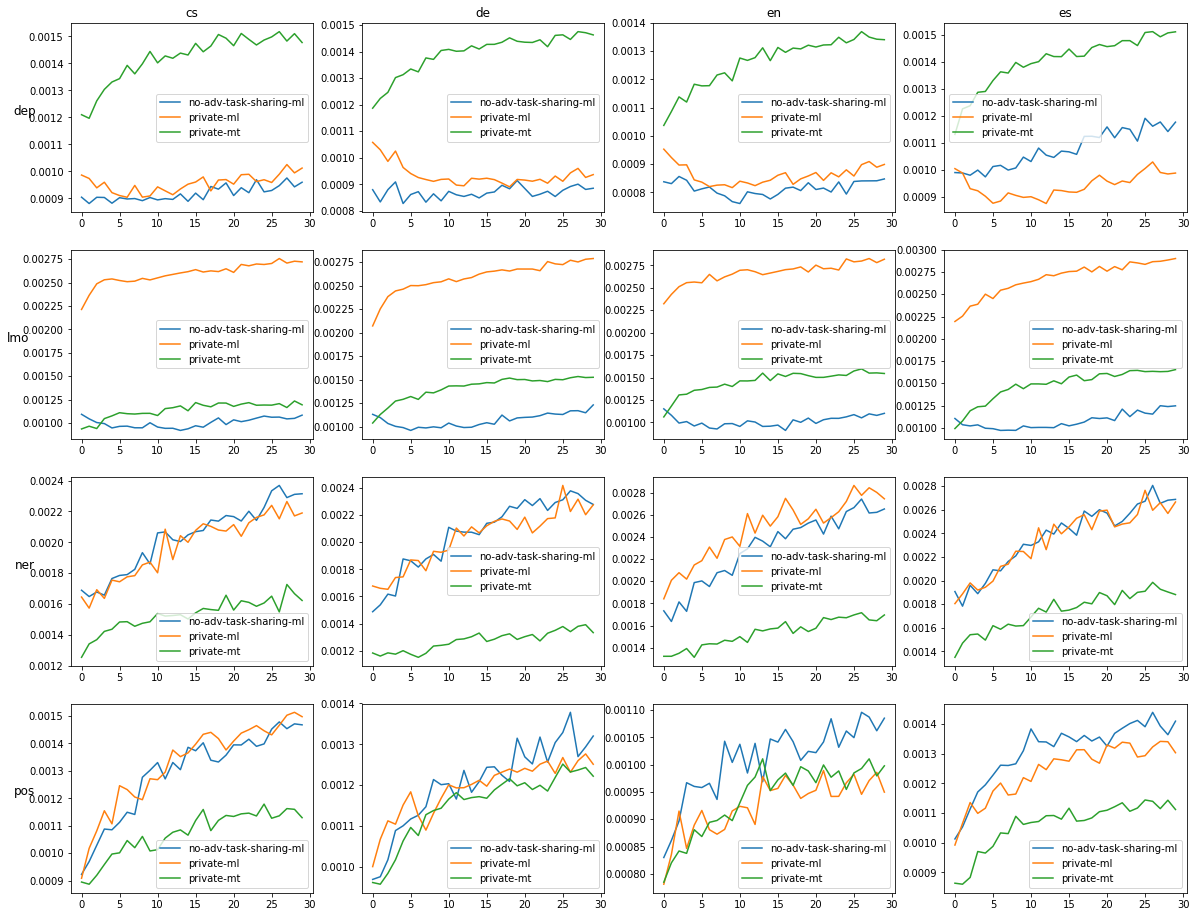

In [5]:
# draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
#              ['private-focused-200', 'no-adv-tsh-200'], ['ml'])
draw_graphs(lambda _: 'unit_strength_2', tasks, langs, 'test',
             ['private', 'no-adv-task-sharing'], ['ml', 'mt'])

In [6]:
pairs = [('dep','cs'), ('dep','es'), ('ner','cs'), ('ner','es'), ('pos','cs'), ('pos','es'),]

def print_row(code, type_):
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))

codes = ['private-focused', 'no-adv-tsh-focused']
types = ['ml', 'mt']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75']
types = ['ml', 'mt']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75', 'private-focused', 'no-adv-tsh-focused']
types = ['mtml']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()


# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.25'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.125'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['no-adv-task-sharing'], ['ml'])

private-focusedml	89.04 86.87 78.24 86.61 98.96 96.69 
private-focusedmt	88.44 86.48 77.40 86.46 99.04 96.72 
no-adv-tsh-focusedml	88.95 86.66 77.91 87.10 99.01 96.71 
no-adv-tsh-focusedmt	87.21 85.93 78.95 86.52 99.05 96.96 
private-focused-0.75ml		89.60 86.62 78.00 86.18 99.05 96.71 
private-focused-0.75mt		88.90 86.69 77.82 86.27 99.05 96.53 
no-adv-tsh-focused-0.75ml		89.47 86.60 78.06 87.35 99.00 96.65 
no-adv-tsh-focused-0.75mt		88.44 86.68 78.12 86.83 99.10 96.48 
private-focused-0.75mtml		89.39 86.57 77.45 86.79 99.04 96.75 
no-adv-tsh-focused-0.75mtml		
private-focusedmtml		
no-adv-tsh-focusedmtml		87.29 86.18 80.03 86.24 98.94 96.66 


In [10]:
import numpy as np

pairs = list(itertools.product(['dep', 'ner', 'pos'], langs))

def print_row(code, type_, msg):
    print(msg, end=' ')
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))
    print()
        
# print_row('vanilla', 'stsl', 'Baseline')

# print('Best1', end=' ')
# for t, l in pairs:
#     output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
#                 ['one-aux'], print_lambda=lambda _, __: ...)
#     print(f'{max([r[0] for r in output]):.2f}', end=' ')
# print()

for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    output = sorted(output, key=lambda r: -r[0])
    print(output[0][1].hparams['tasks'])
#     print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

# print('Avg', end=' ')
# for t, l in pairs:
#     output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
#                 ['one-aux'], print_lambda=lambda _, __: ...)
#     print(f'{np.mean([r[0] for r in output]):.2f}', end=' ')
# print()


# print('Worst1', end=' ')
# for t, l in pairs:
#     output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
#                 ['one-aux'], print_lambda=lambda _, __: ...)
#     print(f'{min([r[0] for r in output]):.2f}', end=' ')
# print()

# print_row('vanilla', 'mt', 'A-MT')
# print_row('no-adv-task-sharing', 'ml', 'A-ML')
# print_row('no-adv-task-sharing', 'mtml', 'A-MTML')
# print_row('private', 'mt', 'C-MT')
# print_row('private', 'ml', 'C-ML')
# print_row('private', 'mtml', 'C-MTML')

[('dep', 'es'), ('dep', 'cs')]
[('dep', 'cs'), ('dep', 'de')]
[('dep', 'es'), ('dep', 'en')]
[('dep', 'es'), ('dep', 'en')]
[('dep', 'cs'), ('ner', 'cs')]
[('ner', 'de'), ('lmo', 'de')]
[('ner', 'cs'), ('ner', 'en')]
[('ner', 'es'), ('lmo', 'es')]
[('dep', 'cs'), ('pos', 'cs')]
[('ner', 'de'), ('pos', 'de')]
[('pos', 'en'), ('lmo', 'en')]
[('pos', 'es'), ('pos', 'en')]



In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test', ['vanilla'])

In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
            run_codes=['vanilla', 'vanilla300', 'vanilla400'],
            run_types=['mtml'])